In [ ]:
#hide
from nbdev import show_doc

%load_ext line_profiler

In [ ]:
#default_exp esf

# esf
> Documentation for the Elliptical Separability Filter

In [ ]:
#export
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse
from tqdm import tqdm

from skimage.feature import peak_local_max

In [ ]:
#export
def expand_dim_to_3(arr):
    if arr.ndim == 2:
        return np.expand_dims(arr, axis=-1)
    elif arr.ndim == 3:
        return arr
    else:
        raise ValueError()

In [ ]:
# export

def elliptic_region(img, center, axes=None, angle=0, r=None, as_image=False, crop=False):
    """Returns the pixels in a elliptic region of a given image.
    
    Parameters:
    - img: 
    - center:
    - axes:
    - angle:
    - r:
    - as_image
    - crop
    """
    assert axes is not None or r is not None, "Either axes or radius must be passed"
    
    cx, cy = center
    a, b = axes
    
    width = img.shape[0]
    height = img.shape[1]
    mask = np.zeros((width, height), np.uint8) 

    circle_img = cv.ellipse(mask, center, axes, angle, color=(255,255,255), thickness=-1, startAngle=0, endAngle=360)
    
    masked_data = cv.bitwise_and(img, img, mask=circle_img)
    if crop:
        m = max(a,b)//2 #margin
        masked_data = masked_data[cy-m:cy+m+1, cx-m:cx+m+1]
        
    masked_data = expand_dim_to_3(masked_data)
    if as_image:
        return masked_data
    else:
        pixels = masked_data[masked_data.sum(axis=2)!=0]
#         pixels = masked_data[masked_data!=(0,0,0)]
        return pixels 


In [ ]:
#export
def regions(img, center, axes_in, axes_out, angle):
    full_region = elliptic_region(img, center, axes_out, angle=angle, as_image=True)

    blank_img = np.ones(full_region.shape[:2], dtype='uint8') * 255
    mask = elliptic_region(blank_img, center=center, axes=axes_in, as_image=True, angle=angle)

    outer_region = cv.bitwise_and(full_region, full_region.copy(), mask=cv.bitwise_not(mask))
    outer_region = expand_dim_to_3(outer_region)
    outer_region = outer_region[outer_region.sum(axis=2)!=0]
    
    inner_region = elliptic_region(full_region, center=center, axes=axes_in, as_image=False, angle=angle)
    return inner_region, outer_region

In [ ]:
#export
def seperability_filter(img, axes_in, axes_out, angle):
    width, height = img.shape[:2]
    result = np.zeros((width, height))
    
    for x in tqdm(range(axes_out[0], width-axes_out[0])):
        for y in range(axes_out[1], height-axes_out[1]):
            
            center = x, y
            r1_pixels, r2_pixels = regions(img, center, axes_in, axes_out, angle)

            
#             r1_pixels = intensity_region_1(img, x, y, r_in, True)
#             r2_pixels = intensity_region_2(img, x, y, r_in, r_out, True)
            if r1_pixels.size==0 or r2_pixels.size==0:
                result[x, y] = 0
                continue
            
            r1_mean = r1_pixels.mean(axis=0, keepdims=True).T
            r2_mean = r2_pixels.mean(axis=0, keepdims=True).T
            
            n_r1 = len(r1_pixels)
            n_r2 = len(r2_pixels)
            
            n_overall = n_r1 + n_r2
            overall_mean = r1_mean * n_r1/n_overall + r2_mean * n_r2/n_overall
                        
            S_B = n_overall * (r1_mean - overall_mean).dot((r1_mean - overall_mean).T) + \
                n_overall * (r2_mean - overall_mean).dot((r2_mean - overall_mean).T)
            
            S_T = np.cov(np.concatenate([r1_pixels, r2_pixels]).T)
            if np.isnan(S_B).any() or np.isnan(S_T).any():
                result[x, y] = 0
            elif S_B.size==1:
                result[x,y] = S_B / S_T
            else:
                result[x,y] = np.trace(S_B) / np.trace(S_T)
                
    return result

In [ ]:
#export

class EllipticalSeparabilityFilter:
    def __init__(self, axes_in, axes_out, angle):
        self.axes_in = axes_in
        self.axes_out = axes_out
        self.angle = angle
        
    def __call__(self, img):
        return seperability_filter(img, self.axes_in, self.axes_out, self.angle)
    
    def find_circles(self, img, num_circles=None):
        sepmap = seperability_filter(img, self.axes_in, self.axes_out, self.angle)
        sepmap[np.isnan(sepmap)]=0
        peaks = peak_local_max(sepmap)
        
        if num_circles is None:
            return peaks
        else:
            return peaks[:num_circles] 
            

## Example using a real image

In [ ]:
%matplotlib inline
def plot_images(imgs):
    fig, axs = plt.subplots(ncols=len(imgs))
    for i, img in enumerate(imgs):
        ax = axs[i]
        ax.imshow(cv.cvtColor(img, cv.COLOR_RGB2BGR))
        ax.axis('off')
    plt.show()

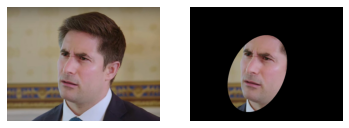

In [ ]:
img = cv.imread('../images/face.jpeg')

angle = 25
center = 500, 500
axes_out = 200, 300
full_region = elliptic_region(img, center, axes_out, angle=angle, as_image=True)

plot_images([img, full_region])

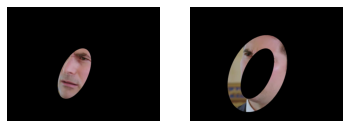

In [ ]:
axes_in = 100, 200

blank_img = np.ones(full_region.shape[:2], dtype='uint8') * 255
mask = elliptic_region(blank_img, center=center, axes=axes_in, as_image=True, crop=False, angle=angle)[:,:,0]
outer_region = cv.bitwise_and(full_region, full_region.copy(), mask=cv.bitwise_not(mask))

inner_region = elliptic_region(full_region, center=center, axes=axes_in, as_image=True, crop=False, angle=angle)
plot_images([inner_region, outer_region])

In [ ]:
csf = EllipticalSeparabilityFilter(axes_in, axes_out, angle)

gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

fig, axs = plt.subplots(2,2, figsize=(8,8))

axs[0,0].imshow(gray, cmap='gray')
axs[0,0].set_title('Grayscale Image')

axs[0,1].imshow(rgb)
axs[0,1].set_title('RGB Image')

res = csf(gray)
axs[1,0].imshow(res)
axs[1,0].set_title('Center Liklihood for Grayscale Image')

res = csf(rgb)
axs[1,1].imshow(res)
axs[1,1].set_title('Center Liklihood for RGB Image')

fig.suptitle(f'Separability Filter for SN ratio of {density}', fontsize=18)
plt.show()

100% 452/452 [38:04<00:00,  5.05s/it]
  6% 27/452 [15:32<4:04:48, 34.56s/it]

## Example using a dummy image

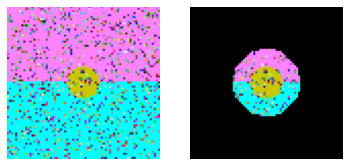

In [ ]:
size = 75
dummy_im = np.zeros((size, size, 3), np.uint8)
dummy_im[:size//2] = (255,130,255)
dummy_im[size//2:] = (255,255,0)

cv.circle(dummy_im, (size//2, size//2), 8, (0,200,200), thickness=-1)
density = 0.2

noise = np.ceil(scipy.sparse.rand(size, size, density).todense()).astype(np.uint8)
dummy_im +=  np.random.randint(0, 255, size=(size,size,3), dtype=np.uint8) * np.expand_dims(noise, axis=-1)

angle = 25
center = size//2, size//2
axes_out = 16, 16
full_region = elliptic_region(dummy_im, center, axes_out, angle=angle, as_image=True)

plot_images([dummy_im, full_region])

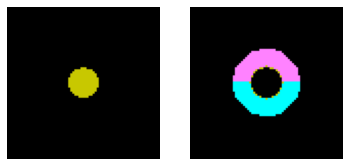

In [ ]:
axes_in = 7, 7

blank_img = np.ones(full_region.shape[:2], dtype='uint8') * 255
mask = elliptic_region(blank_img, center=center, axes=axes_in, as_image=True, crop=False, angle=angle)[:,:,0]
outer_region = cv.bitwise_and(full_region, full_region.copy(), mask=cv.bitwise_not(mask))

inner_region = elliptic_region(full_region, center=center, axes=axes_in, as_image=True, crop=False, angle=angle)
plot_images([inner_region, outer_region])

100% 43/43 [00:00<00:00, 66.86it/s]
100% 43/43 [00:01<00:00, 36.88it/s]


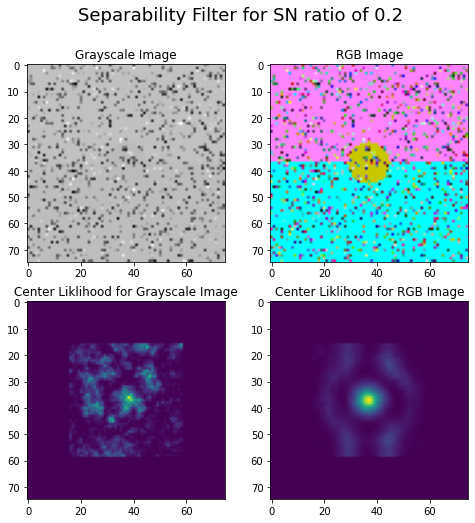

In [ ]:
#example
csf = EllipticalSeparabilityFilter(axes_in, axes_out, angle)

gray = cv.cvtColor(dummy_im, cv.COLOR_BGR2GRAY)
rgb = cv.cvtColor(dummy_im, cv.COLOR_BGR2RGB)

fig, axs = plt.subplots(2,2, figsize=(8,8))

axs[0,0].imshow(gray, cmap='gray')
axs[0,0].set_title('Grayscale Image')

axs[0,1].imshow(rgb)
axs[0,1].set_title('RGB Image')

res = csf(gray)
axs[1,0].imshow(res)
axs[1,0].set_title('Center Liklihood for Grayscale Image')

res = csf(rgb)
axs[1,1].imshow(res)
axs[1,1].set_title('Center Liklihood for RGB Image')

fig.suptitle(f'Separability Filter for SN ratio of {density}', fontsize=18)
plt.show()